In [1]:
#######################################################################################################
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import sys

# Get the current notebook's directory
notebook_dir = os.path.abspath('')
# Add the relative path to your Codes directory
codes_path = os.path.join(notebook_dir, "..", "Codes")
codes_path = os.path.abspath(codes_path)  # Normalize the path
# Add to path if not already there
if codes_path not in sys.path:
    sys.path.insert(1, codes_path)
from myUtils import *

MAINPATH is set to: /home/emanuele/Research/APES/FHN/


In [2]:
def detect_turning_points(years, values, slope_threshold=0.5):
    """
    Detect turning points in a time series where the slope changes significantly.
    
    Parameters:
    - years: array of years (x-values)
    - values: array of measurements (y-values)
    - slope_threshold: minimum absolute difference in slopes to consider a turning point
    
    Returns:
    - turning_points: indices of detected turning points
    - turning_years: years where turning points occur
    - turning_values: values at turning points
    """
    # Calculate time intervals
    time_intervals = np.diff(years)
    
    # Calculate slopes between consecutive points
    slopes = np.diff(values) / time_intervals
    
    turning_points = []
    # Start from the second point and end at the second-to-last point
    for i in range(1, len(slopes)):
        # Calculate slope difference
        slope_diff = slopes[i] - slopes[i-1]
        
        # Check for sign change
        sign_change = (slopes[i-1] > 0 and slopes[i] < 0) or (slopes[i-1] < 0 and slopes[i] > 0)
        
        # Handle the case where one slope is exactly zero
        if slopes[i-1] == 0 or slopes[i] == 0:
            sign_change = True
        
        # Check if slope exceeds threshold and changes sign
        if sign_change and (abs(slope_diff) > slope_threshold):
            # The turning point is at index i in the original series
            turning_points.append(i)
    
    turning_years = years[turning_points]
    turning_values = values[turning_points]
    
    return turning_points, turning_years, turning_values

In [8]:
# Custom regions shapefiles 
shapef = os.path.join(MAINPATH, 'Data/SHAPEFILES/world-custom_regions_r.shp')
gdf1 = gpd.read_file(shapef)
gdf1 = gdf1.to_crs("ESRI:54009")
REGIONS = gdf1['custom_reg']

# Define the fixed number of rows (continents)
continent_order = ["Africa", "Asia", "America", "Oceania", "Europe"]
rows = len(continent_order)

In [54]:
REGIONS = gdf1['custom_reg'].unique()
DF_all = pd.DataFrame()
SUBP1 = ['FAC']

for subp1 in SUBP1:
    print(subp1)
    
    # Load data once per subp1
    PATHL = os.path.join(MAINPATH, 'Data', 'OUTPUT', subp1, subp1+'_{window}_{year}.tif')
    df = return_df(PATHL, gdf1)
    
    # Create a DataFrame with all regions
    DF = pd.DataFrame()
    for region in REGIONS:
        region_df = df[df["region"] == region].sort_values("year")
        DF = pd.concat([DF, region_df], ignore_index=True)
    
    # Calculate relative temporal variation
    col_to_plot = 'mean'
    new_col = col_to_plot+'_rel'
    DF[new_col] = 0
    
    for region in REGIONS:
        # Get indices and sorted data for this region
        region_indices = DF[DF["region"] == region].index
        df_region = DF[DF["region"] == region].sort_values("year").reset_index(drop=True)
        
        if len(df_region) > 0:  # Add safety check
            # Calculate relative change
            signal = df_region[col_to_plot].values
            baseline = signal[0]
            if baseline != 0:  # Add safety check for division by zero
                signal = 100 * (signal - baseline) / baseline
                # Update values in original DataFrame
                DF.loc[region_indices, new_col] = signal
    
    # First iteration: initialize DF_all with structure
    if DF_all.empty and not DF.empty:
        DF_all = pd.DataFrame({
            'year': DF['year'],
            'region': DF['region']
        })
    
    # Add columns for this subp1
    if not DF.empty:
        new_col1 = col_to_plot + f'_{subp1}'
        new_col2 = new_col + f'_{subp1}'
        DF_all[new_col1] = DF[col_to_plot]
        DF_all[new_col2] = DF[new_col]

FAC


In [55]:
DF_all["Continent"] = DF_all["region"].map(REGION_TO_CONTINENT)
# Get unique regions per continent
regions_by_continent = {continent: DF_all[DF_all["Continent"] == continent]["region"].unique() \
                        for continent in continent_order}
# Determine the maximum number of columns based on the continent with the most regions
cols = max(len(regions) for regions in regions_by_continent.values())

In [56]:
DF_all.head()

,year,region,mean_FAC,mean_rel_FAC,Continent
0,1975,Central Asia,14.270638,0.000000,Asia
1,1980,Central Asia,12.976895,-9.065769,Asia
2,1985,Central Asia,13.146362,-7.878247,Asia
3,1990,Central Asia,13.053170,-8.531281,Asia
4,1995,Central Asia,13.742923,-3.697912,Asia


In [58]:
col_to_plot = 'mean_rel_FAC'

Eastern Africa: found 2 turning points
Middle Africa: found 5 turning points
Northern Africa: found 1 turning points
Southern Africa: found 3 turning points
Western Africa: found 0 turning points
Central Asia: found 7 turning points
Eastern Asia: found 3 turning points
South-Eastern Asia: found 2 turning points
Southern Asia: found 2 turning points
Western Asia: found 2 turning points
Northern America: found 1 turning points
South America: found 1 turning points
Oceania: found 5 turning points
Eastern Europe: found 1 turning points
Northern Europe: found 4 turning points
Southern Europe: found 2 turning points
Western Europe: found 2 turning points


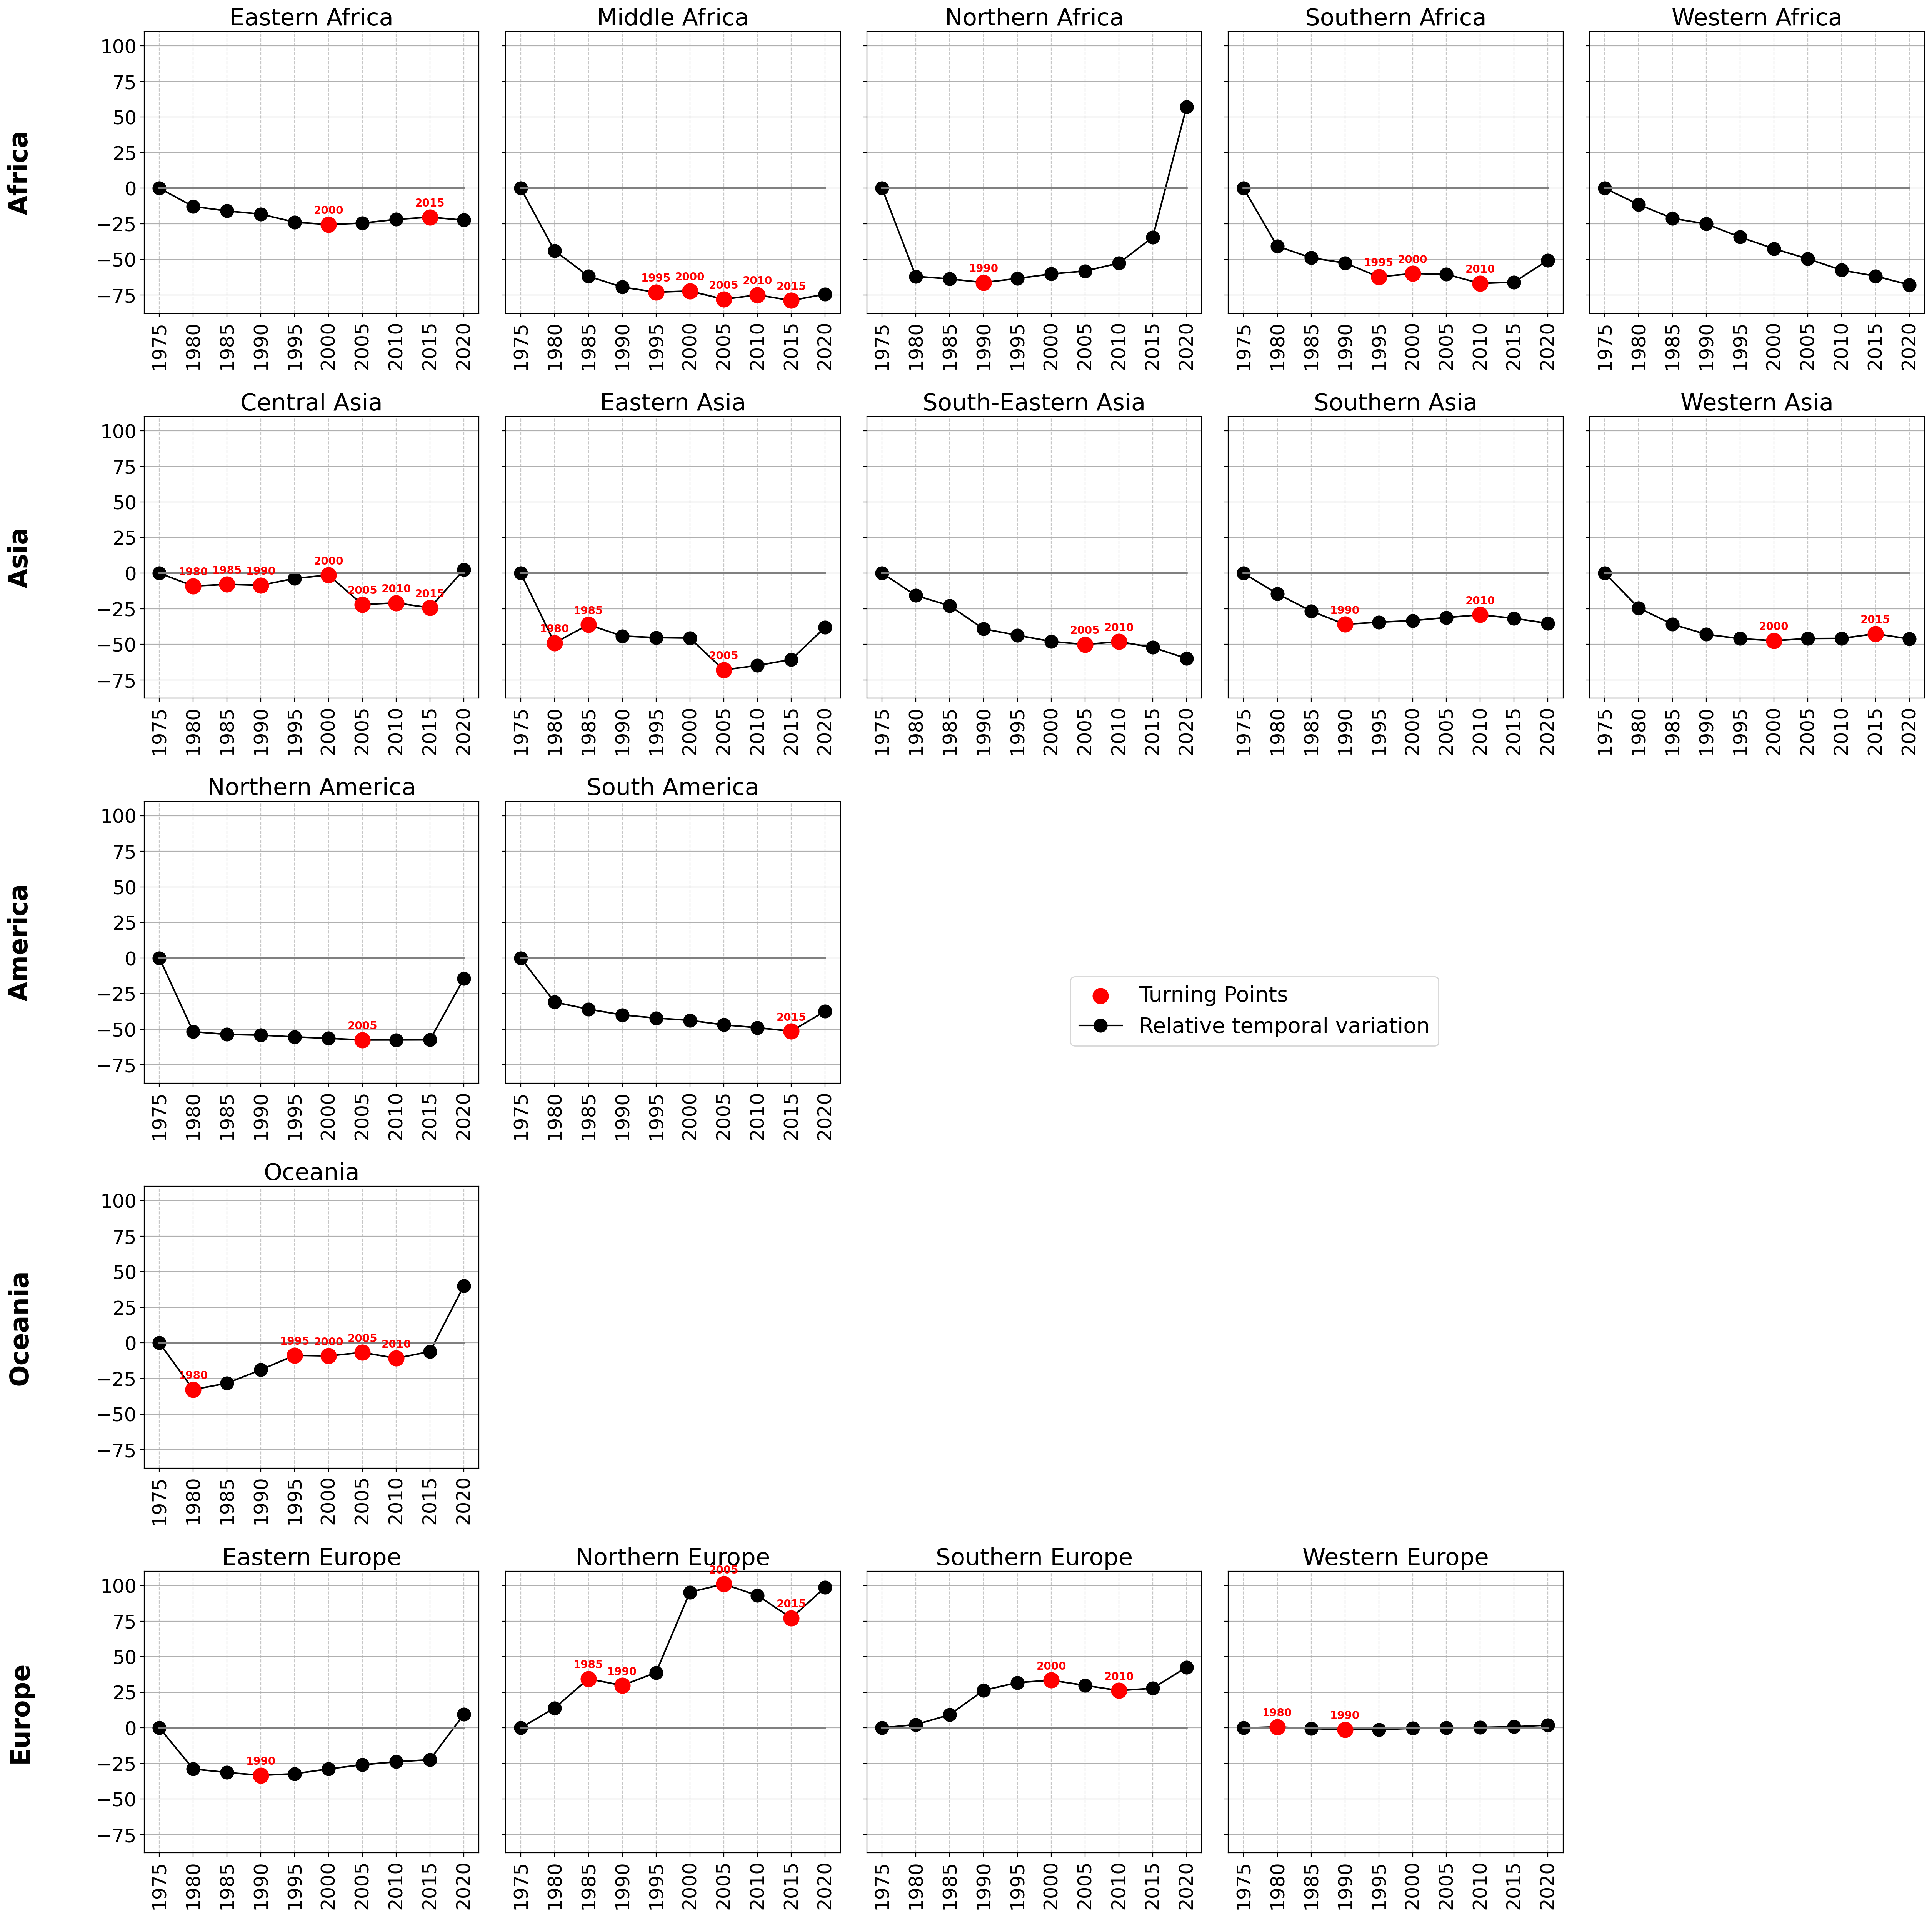

In [59]:
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), 
                         constrained_layout=True, sharex=False, sharey=True)
# Ensure axes is a 2D array
if rows == 1:
    axes = np.expand_dims(axes, axis=0)
if cols == 1:
    axes = np.expand_dims(axes, axis=1)
    
# Dictionary to store unique legend handles and labels
unique_handles = {}    

# Iterate over continents and regions to populate the subplots
for row_idx, continent in enumerate(continent_order):
    regions = regions_by_continent[continent]
    for col_idx, region in enumerate(regions):
        ax = axes[row_idx, col_idx]  # Get the corresponding subplot
        ax = set_font(ax, 18)
        
        # Get data for this region
        df_region = DF_all[DF_all["region"] == region].sort_values("year")
        
        # Calculate turning points
        slope_threshold = 0.001  # Adjust as needed
        years = df_region['year'].values
        values = df_region[col_to_plot].values
        
        indices, turning_years, turning_values = detect_turning_points(years, values, slope_threshold)
        print(f"{region}: found {len(turning_years)} turning points")
        
        # Plot the main line
        line1, = ax.plot(df_region["year"], df_region[col_to_plot], marker="o", 
                         markersize=12, color="black", label="Relative temporal variation")
        
        # Plot the zero reference line
        line2, = ax.plot([1975, 2020], [0, 0], lw=2, color='gray')
        
        # Plot turning points with higher z-order to ensure visibility
        if len(turning_years) > 0:
            tp_scatter = ax.scatter(turning_years, turning_values, color='red', 
                                   s=200, zorder=10, label='Turning Points')
            unique_handles['Turning Points'] = tp_scatter
            
            # Optional: Add text labels for turning points
            for year, value in zip(turning_years, turning_values):
                ax.annotate(f"{year}", (year, value), xytext=(0, 10), 
                           textcoords='offset points', ha='center', color='red', fontweight='bold')
        
        # Store handles for legend
        unique_handles['Relative temporal variation'] = line1
        
        # Set labels and title
        ax.set_xlabel(" ")
        ax.set_ylabel(" ")
        ax.set_title(region, size=22)
        ax.grid(True)
        
    # Hide unused subplots in this row
    for col_idx in range(len(regions), cols):
        fig.delaxes(axes[row_idx, col_idx])

# Set row labels (continent names)
for row_idx, continent in enumerate(continent_order):
    ax = axes[row_idx, 0]
    ax.set_ylabel(f"{continent}\n\n ", fontsize=24, fontweight="bold")

# Place the legend outside the plot
fig.legend(unique_handles.values(), unique_handles.keys(),
           bbox_to_anchor=(0.65, 0.5),  # Adjust position as needed
           loc='upper center', ncol=len(unique_handles)-1, fontsize=20)

# Set x-axis ticks
all_years = np.arange(1975, 2021, 5)
for ax in axes.flatten():
    if ax.get_subplotspec().get_geometry()[2] < rows * cols:  # Check if not deleted
        ax.set_xticks(all_years)
        ax.set_xticklabels(all_years, rotation=90)
        ax.grid(True, which="major", axis="x", linestyle="--", alpha=0.7)

plt.show()

In [48]:
# Save Figure 1C
fout = '../Figures/FigureFAP_SI1.pdf'
fig.savefig(fout, dpi=300, bbox_inches='tight')

In [28]:
### Mean Kendal

In [60]:
import pymannkendall as mk  # Use pymannkendall for Sen's slope and Mann-Kendall test
import seaborn as sns
from scipy import stats
results_list = []
# For each region, plot data and calculate Sen's slope
for i, region in enumerate(REGIONS):
    df_region = DF_all[DF_all["region"] == region].sort_values("year")
    
    # Extract x and y data
    x = df_region['year'].values
    y = df_region[col_to_plot].values
    
    # Plot the original data
    
    # Run Mann-Kendall test and Sen's slope analysis
    mk_result = mk.original_test(y, alpha=0.05)
    
    # Get the slope
    slope = mk_result.slope

    # Calculate the trend line using Sen's slope
    y_start = mk_result.intercept + mk_result.slope * x[0]
    y_end = mk_result.intercept + mk_result.slope * x[-1]

    # Get significance stars
    significance = ''
    if mk_result.p < 0.001:
        significance = '***'
    elif mk_result.p < 0.01:
        significance = '**'
    elif mk_result.p < 0.05:
        significance = '*'
    else:
        significance = 'ns'
    
    # Add results to list
    results_list.append({
        'Region': region,
        'Slope': slope,
        'p-value': mk_result.p,
        'Significance': significance,
        'Trend': mk_result.trend,
        'Intercept': mk_result.intercept
    })

# Create a results dataframe
results_df = pd.DataFrame(results_list)

In [61]:
results_df

,Region,Slope,p-value,Significance,Trend,Intercept
0,Central Asia,-1.178283,0.591505,ns,no trend,-2.902491
1,Eastern Africa,-1.648350,0.049098,*,decreasing,-13.656999
2,Eastern Asia,-3.792354,0.152406,ns,no trend,-28.381059
3,Eastern Europe,1.495221,0.107405,ns,no trend,-34.122425
4,Middle Africa,-3.545807,0.002358,**,decreasing,-56.620419
5,Northern Africa,2.852188,0.073638,ns,no trend,-71.996895
6,Northern America,-0.917937,0.049098,*,decreasing,-50.608448
7,Northern Europe,10.609876,0.007290,**,increasing,10.201471
8,Oceania,3.817869,0.073638,ns,no trend,-26.080360
9,South America,-2.586845,0.004208,**,decreasing,-29.382357


In [62]:
results_df = results_df.sort_values('Slope')
colors = results_df['Region'].map(REGION_TO_CONTINENT).map(CONTINENT_COLORS)

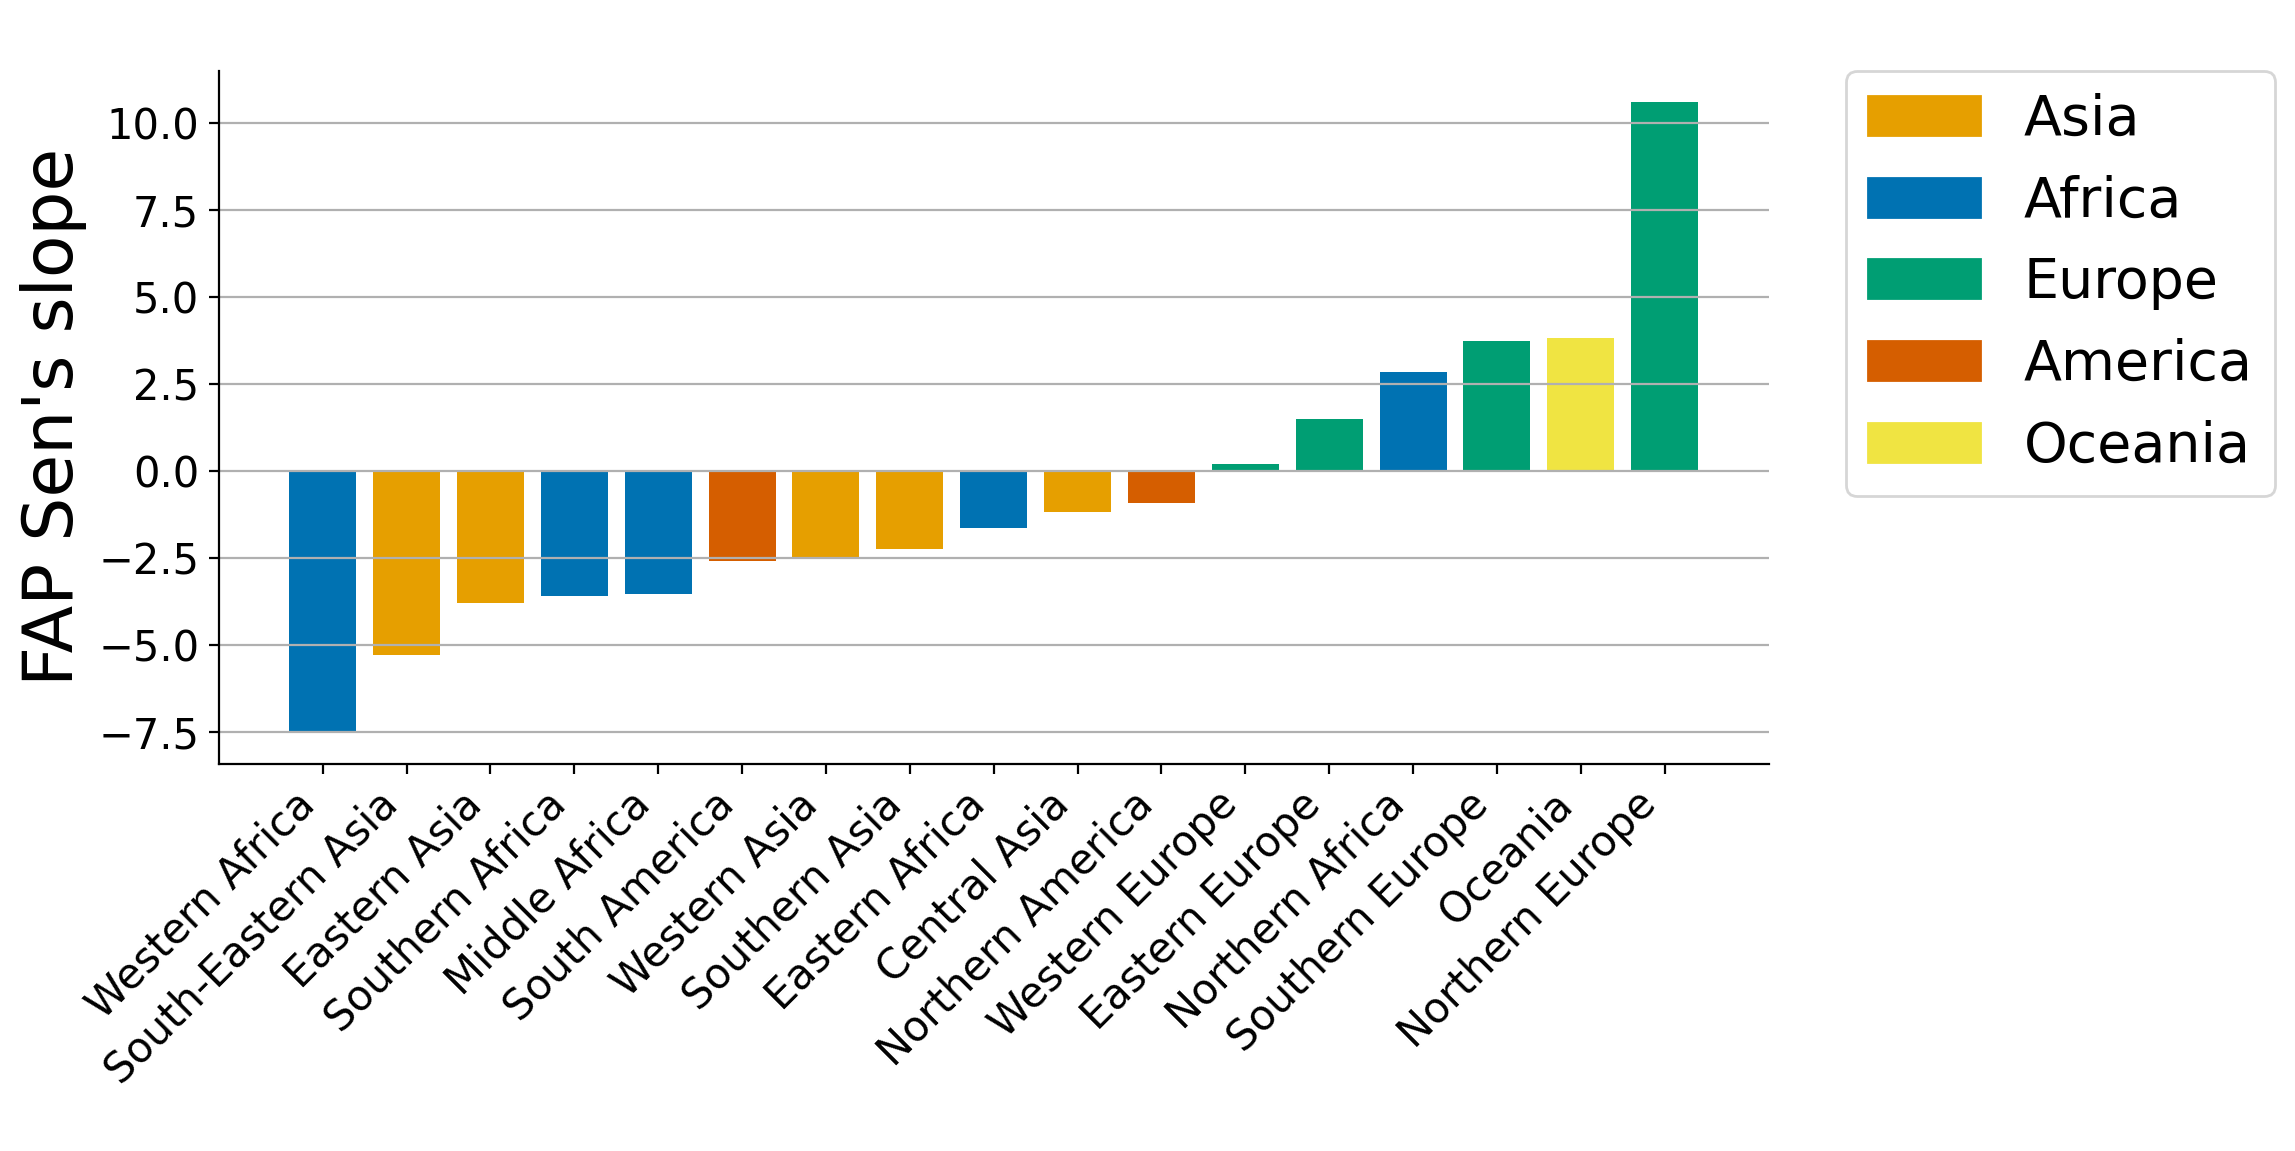

In [63]:
# Plotting the bar plot
f, ax = plt.subplots(figsize=(10, 4.5))
ax = set_font(ax, 15)
plt.bar(results_df['Region'], results_df['Slope'], color=colors)
# Adding labels and title
plt.xlabel(' ')
plt.ylabel('FAP '+"Sen's slope", size=25)
plt.title(' ', size=16)
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Creating legend patches
patches = [mpatches.Patch(color=color, label=continent) for continent, color in CONTINENT_COLORS.items()]
# Adding the legend outside the plot
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20)
plt.xticks(rotation=45, ha='right');

In [53]:
# Save Figure 1C
fout = '../Figures/FigureFAP_SI2.pdf'
fig.savefig(fout, dpi=300, bbox_inches='tight')